In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os



/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [2]:
# #list_ds = tf.data.Dataset.list_files('data/jetImages*.npz')
# list_ds = tf.data.Dataset.list_files('/mnt/data/ml/ShowJetsData.npz')

# l_jetImages = []
# l_labels = []
# n = 5 #take number of files
# n_images = 0 #number of images in one file
# for f1 in list_ds.take(n):
#     print(f1.numpy())
#     with np.load(f1.numpy()) as data:

#         jetImages  = np.array(data['jetImages'])
#         n_images += len(jetImages)
#         l_jetImages.append(jetImages)
#         labels  = data['labels']
#         l_labels.append(labels)
#         print(labels.shape)
#         print(jetImages.shape)


# l_jetImages = np.array(l_jetImages).reshape(n_images,16,16,1)
# l_labels = np.array(l_labels).reshape(n_images,4)


In [3]:
data = np.load('/mnt/data/ml/ShowJetsDataTest.npz')
# !ls /mnt/data/ml/
images = data['jetImages']
labels = data['labels']
tau21 = data['tau21']
chMult = data['chMult']

## data = stack all of them, then split them up after

print(chMult.shape)

grid = np.size(images, 1)
#ensure same number of signal vs. background and even split of z events
qcd_im = images[np.where(labels[:,0] == 1)]
qcd_tau = tau21[np.where(labels[:,0] == 1)]
qcd_mult = chMult[np.where(labels[:,0] == 1)]

if len(qcd_im) % 3 != 0:
    qcd_im = qcd_im[:len(qcd_im)-(len(qcd_im) % 3)]
    qcd_tau = qcd_tau[:len(qcd_im)-(len(qcd_im) % 3)]
    qcd_mult = qcd_mult[:len(qcd_im)-(len(qcd_im) % 3)]

z1_im = images[np.where(labels[:,1] == 1)]
z1_im = z1_im[:int(len(qcd_im)/3)]
z1_tau = tau21[np.where(labels[:,1] == 1)]
z1_tau = z1_tau[:int(len(qcd_im)/3)]
z1_mult = chMult[np.where(labels[:,1] == 1)]
z1_mult = z1_mult[:int(len(qcd_im)/3)]

z2_im = images[np.where(labels[:,2] == 1)]
z2_im = z2_im[:int(len(qcd_im)/3)]
z2_tau = tau21[np.where(labels[:,2] == 1)]
z2_tau = z2_tau[:int(len(qcd_im)/3)]
z2_mult = chMult[np.where(labels[:,2] == 1)]
z2_mult = z1_mult[:int(len(qcd_im)/3)]

z3_im = images[np.where(labels[:,3] == 1)]
z3_im = z3_im[:int(len(qcd_im)/3)]
z3_tau = tau21[np.where(labels[:,3] == 1)]
z3_tau = z3_tau[:int(len(qcd_im)/3)]
z3_mult = chMult[np.where(labels[:,3] == 1)]
z3_mult = z1_mult[:int(len(qcd_im)/3)]

qcd_lab = np.zeros([len(qcd_im), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_im), 2])
z_lab[:,1] = 1
images = np.vstack((qcd_im, z1_im, z2_im, z3_im))
taus = np.hstack((qcd_tau, z1_tau, z2_tau, z3_tau))
mults = np.hstack((qcd_mult, z1_mult, z2_mult, z3_mult))
labels = np.vstack((qcd_lab, z_lab))
n_data = len(images)
images = images.reshape(n_data, grid, grid, 1)
#split data into testing/training/validation
testimages = images[::4]
testlabels = labels[::4]
testtaus = taus[::4]
testmults = mults[::4]
mask_im = np.ones(images.shape,dtype=bool)
mask_im[::4] = 0
mask_im[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
mask_tau = np.ones(taus.shape,dtype=bool)
mask_tau[::4] = 0
mask_tau[1::8] = 0
mask_mult = np.ones(mults.shape,dtype=bool)
mask_mult[::4] = 0
mask_mult[1::8] = 0
valimages = images[1::8]
vallabels = labels[1::8]
valtaus = taus[1::8]
valmults = mults[1::8]
trainimages = images[mask_im].reshape((n_data-len(testimages)-len(valimages)), grid, grid, 1)
trainlabels = labels[mask_lab].reshape((n_data-len(testimages)-len(valimages)), 2)
traintaus = taus[mask_tau].reshape((n_data-len(testimages)-len(valimages)), 1)
trainmults = mults[mask_mult].reshape((n_data-len(testimages)-len(valimages)), 1)

print(trainimages.shape)
print(trainlabels.shape)
print(traintaus.shape)
print(trainmults.shape)
print()
print(valimages.shape)
print(vallabels.shape)
print(valtaus.shape)
print(valmults.shape)
print()
print(testimages.shape)
print(testlabels.shape)
print(testtaus.shape)
print(testmults.shape)

(336227,)
(62025, 16, 16, 1)
(62025, 2)
(62025, 1)
(62025, 1)

(12405, 16, 16, 1)
(12405, 2)
(12405,)
(12405,)

(24810, 16, 16, 1)
(24810, 2)
(24810,)
(24810,)


In [4]:
# import list of files

# filelist = tf.data.Dataset.list_files(str('data/jetImages*.npz'))
# initialize new array and concatenate / append array to initialized array [DOES NOT WORK] trying zip


# for f1 in filelist_sig.take(1):
#     with np.load(f1.numpy()) as data:
#         jetImages = data['jetImages']
#         labels = data['labels']
        
# dataset = tf.data.Dataset.from_tensor_slices((l_jetImages, l_labels))
# batched_dataset = dataset.batch(4)


#for batch in batched_dataset.take(1):
#    print([arr.numpy() for arr in batch])


In [5]:
# grid = 16

# trainimages = l_jetImages[10:]
# trainlabels = l_labels[10:]

# testimages = l_jetImages[:10]
# testlables = l_labels[:10]

# print(trainimages.shape)
# print(trainlabels.shape)

In [6]:
# grid = 16
# # training data : 10,000 signal samples and 10,000 bkg samples
# #traindata_sig = np.load('data/jetImages_signal.npz')
# #traindata_bkg = np.load('data/jetImages_bkg.npz')
# trainimages = np.concatenate((traindata_sig['jetImages'], traindata_bkg['jetImages']),axis=0)
# trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
# # testing data : 10,000 signal samples and 10,000 bkg samples
# testdata_sig = np.load('data/jetImages_signal_test.npz')
# testdata_bkg = np.load('data/jetImages_bkg_test.npz')
# testimages = np.concatenate((testdata_sig['jetImages'], testdata_bkg['jetImages']),axis=0)
# testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)

# n_test = len(testlabels)
# n_train = len(trainlabels)
# trainimages = trainimages.reshape(n_train, grid, grid, 1)
# testimages = testimages.reshape(n_test, grid, grid, 1)
# print(trainimages.shape)
# print(trainlabels.shape)

In [7]:
# dataset = tf.data.Dataset.from_tensor_slices((l_jetImages, l_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((testimages, testlabels))

# batched_test_dataset = test_dataset.batch(4)

#for batch in batched_dataset.take(4):
#  print([arr.numpy() for arr in batch])


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

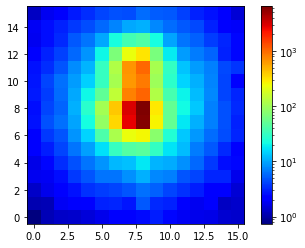

In [4]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if trainlabels[i,0] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

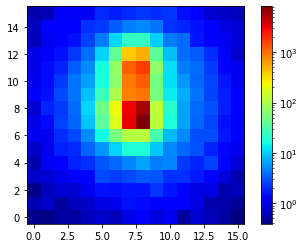

In [5]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [10]:
# def build_model():
#     model = keras.Sequential([
#         Conv2D(32, (11, 11), activation='relu',
#                input_shape=(grid, grid, 1)),
#         Conv2D(32, (3, 3), activation='relu'),
#         MaxPool2D((2, 2)),
# #         Dropout(0.2),
#         Conv2D(32, (3, 3), activation='relu'),
#         Conv2D(32, (3, 3), activation='relu'),
#         MaxPool2D((2, 2)),
# #         Dropout(0.2),
#         Flatten(),
#         #custom input layer
#         Dense(64, activation=tf.nn.relu),
#         Dense(64, activation=tf.nn.relu),
# #         Dropout(0.2),
#         Dense(1, activation=tf.nn.sigmoid)])

#     model.compile(loss='binary_crossentropy',
#                 optimizer='adam',
#                 metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
#     return model

In [11]:
import tensorflow as tf

def build_model():
    input1 = layers.Input(shape = (grid, grid, 1))
    x = layers.Conv2D(64, (12, 12), activation='relu', padding = 'same')(input1)
    x = layers.Conv2D(64, (6, 6), activation='relu', padding = 'same')(x)
    x = layers.Conv2D(64, (4, 4), activation='relu', padding = 'same')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x1 = layers.Flatten()(x)
    input2 = layers.Input(shape=(1,))
    #input3 = layers.Input(shape=(1,))
    #input4 = layers.Input(shape=(1,))
    x = layers.concatenate(inputs = [x1, input2],axis=-1)
    x = layers.Dense(256, activation=tf.nn.relu)(x)
    output = layers.Dense(2, activation=tf.nn.sigmoid)(x)
    model = models.Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

Initialize model:

In [12]:
circleCNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


Test model's prediction $before$ training:

In [13]:
example_batch = trainimages[::300]
example_labels = trainlabels[::300]
example_taus = traintaus[::300]
example_mults = trainmults[::300]
print(example_taus.shape)
print(example_batch.shape)
print(example_mults.shape)


example_result = circleCNN.predict(x = [example_batch, example_taus])
results = circleCNN.evaluate(x = [example_batch, example_taus], y = example_labels)
print(example_result)
# print(results)

(207, 1)
(207, 16, 16, 1)
(207, 1)
207/207 [==============================] - 0s 2ms/step
[[0.5025403  0.49960783]
 [0.5037716  0.49885908]
 [0.5045614  0.4982309 ]
 [0.5042055  0.49881977]
 [0.5056183  0.49802828]
 [0.50475615 0.49831176]
 [0.506357   0.49734217]
 [0.5058     0.49803948]
 [0.5038267  0.4987353 ]
 [0.5055017  0.4984029 ]
 [0.5034248  0.499143  ]
 [0.50505626 0.49818018]
 [0.50419474 0.4985114 ]
 [0.5030866  0.4991826 ]
 [0.5047773  0.4984386 ]
 [0.5063556  0.49796012]
 [0.5041134  0.49858603]
 [0.5043482  0.49859974]
 [0.5044526  0.4981297 ]
 [0.50524753 0.49819672]
 [0.507083   0.49741948]
 [0.5055952  0.49808055]
 [0.5063224  0.4974431 ]
 [0.50480604 0.49822834]
 [0.50579685 0.49761608]
 [0.50532883 0.4980293 ]
 [0.5042604  0.4986101 ]
 [0.5053842  0.49785152]
 [0.50579    0.4980713 ]
 [0.5065559  0.4980944 ]
 [0.5056213  0.49824575]
 [0.50601524 0.49774393]
 [0.50645643 0.49717927]
 [0.5056187  0.49777597]
 [0.5067769  0.4976396 ]
 [0.50537515 0.49773383]
 [0.504983

In [14]:
# example_batch = trainimages[:10]
# example_labels = trainlabels[:10]
# example_result = circleCNN.predict(example_batch)
# results = circleCNN.evaluate(example_batch, example_labels)
# print(example_result)
# print(results)

Now train! (warning: if building CNN, computer tends to get loud)

In [ ]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
    
checkpoint_path = "model/CNN_cat_multi_input.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = circleCNN.fit(
  #[trainimages, traintaus, trainmults], trainlabels,
  [trainimages, traintaus], trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.67610, saving model to model/CNN_cat_multi_input.h5

Epoch 00002: val_loss improved from 0.67610 to 0.63296, saving model to model/CNN_cat_multi_input.h5

Epoch 00003: val_loss improved from 0.63296 to 0.58685, saving model to model/CNN_cat_multi_input.h5

Epoch 00004: val_loss did not improve from 0.58685

Epoch 00005: val_loss did not improve from 0.58685

Epoch 00006: val_loss did not improve from 0.58685

Epoch 00007: val_loss did not improve from 0.58685

Epoch 00008: val_loss did not improve from 0.58685

Epoch 00009: val_loss did not improve from 0.58685


In [16]:
#dataset_shuffled = dataset.shuffle(buffer_size=1024).batch(16)

In [ ]:
# # WITH BATCHING AND SHUFFLING



# EPOCHS = 1
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = circleCNN.fit(
#   dataset_shuffled,
#   epochs=EPOCHS)

Now make a plot that shows the pregression of accuracy through each training epoch.

In [ ]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch
    
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error')
#     plt.plot(hist['epoch'], hist['mean_squared_error'],
#              label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#              label = 'Val Error')
#     plt.ylim([0,100])
#     plt.legend()
#     plt.show()

# plot_history(history)

Load best weights.

In [8]:
!ls model
best_model = keras.models.load_model('model/CNN_cat_multi_input_taus.h5')
best_model.summary()
#results = best_model.evaluate([testimages, testtaus, testmults], testlabels)
results = best_model.evaluate([testimages, testtaus], testlabels)
print(results)

CNN_cat_multi_input_3inputs.h5	CNN_cat_multi_input.h5	     CNN_sparce_cat.h5
CNN_cat_multi_input_5E.h5	CNN_cat_multi_input_taus.h5  RNN.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   147520      conv2d_1[0][0]                   
________________________________________________

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

(24810,)
(24810, 16, 16, 1)
(24810, 2)


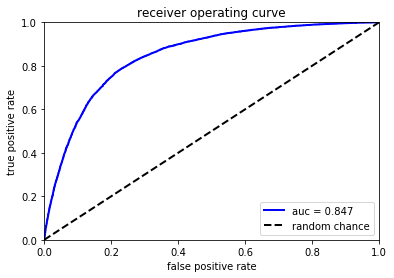

In [9]:
# Plot ROC

print(testtaus.shape)
print(testimages.shape)
print(testlabels.shape)

#predict = best_model.predict([testimages, testtaus, testmults])
predict = best_model.predict([testimages, testtaus])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,0], predict[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

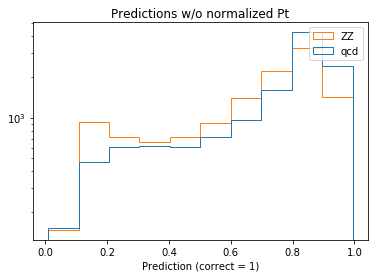

In [10]:
indqcd = np.argwhere(testlabels[:,1] == 0)
ind1  = np.where(testlabels[:,1] == 1) 
# ind2  = np.where(testlabels[:,2] == 1)
# ind3  = np.where(testlabels[:,3] == 1)
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[ind1, 1].flatten()] , histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/o normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()

$$ \textbf{LRP} $$

In [ ]:
# import innvestigate
# import innvestigate.utils as iutils

In [ ]:
# # Creating an analyzer
# lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
# #discoverered that innvestigate fails to run on a loaded model --> trying to find fix

# # Applying the analyzer
# display = trainimages[1].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
# analysis = lrp_analyzer.analyze(display)

# # Displaying one result
# plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar()
# plt.show()

In [ ]:
# #fix - change to predicted labels
# #plot output signal and background
# sig_analysis_true = np.zeros_like(analysis)
# bkg_analysis_true = np.zeros_like(analysis)
# sig_analysis_pred = np.zeros_like(analysis)
# bkg_analysis_pred = np.zeros_like(analysis)
# # sig_mask = trainlabels == 1
# # bkg_mask = trainlabels == 0
# # pred_sig_mask = predict >= 0.50
# # pred_bkg_mask = predict < 0.50

# toc = time.time()

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] == 1:
#         sig_analysis_true += analysis  
#     else:
#         bkg_analysis_true += analysis

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] >= 0.50:
#         sig_analysis_pred += analysis  
#     else:
#         bkg_analysis_pred += analysis

# tic = time.time()

# print('/n time = /n', tic-toc)


In [ ]:
# Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# ax.add_subplot(121)
# im = plt.imshow(sig_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)
# ax.add_subplot(122)
# im_ = plt.imshow(sig_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)

In [ ]:
# # Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# plt.subplot(121)
# im_ = plt.imshow(bkg_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)
# plt.subplot(122)
# im = plt.imshow(bkg_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)